## NetREX+ on yeast data with changes to C matrix

In [36]:
#NETREX
#needed for package

import numpy as np
import pandas as pd
import sys
from implicit import als
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
from pylab import *
from cvxpy import *
import argparse
import mosek
from scipy.sparse import csr_matrix
import copy


#testing
import warnings
#netrex

class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=10, iternum = 300, p = 30, solver = ECOS):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = C #matrix of confidences (weights)
        
        #set initial S to C
        self.S = C
        
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #controls amount of factors in xi/yj
        self.p = p
        #set solver
        self.solver = solver
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #!!! other parameters!!!
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = als.AlternatingLeastSquares(factors=self.p)
        #add to get new weight matrix
        C_adj = 1 + 40*self.C
        self.C = copy.deepcopy(C_adj)
    
        
        #train model on weight matrix
        #implicit_model.fit(csr_matrix(C_cutoff))
        implicit_model.fit(csr_matrix(C_adj))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        for i in self.i_:
            TmpNorm = np.linalg.norm(self.X[:,i])
            if TmpNorm < 1E-5:
                continue
            self.X[:,i] = self.X[:,i] / TmpNorm
        np.nan_to_num(self.X, copy=False)
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        for j in self.j_:
            TmpNorm = np.linalg.norm(self.Y[:,j])
            if TmpNorm < 1E-5:
                continue
            self.Y[:,j] = self.Y[:,j] / TmpNorm
        np.nan_to_num(self.Y, copy=False)
        
        #set initial S to C
        #self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        #S_init = (self.S > 0).astype(int)
        #initialize A using NetREX 1 closed form
        #!!!!!Other options!!!!!
        #Abound = 1.0
        #self.A = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        #self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                       # np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        
        #try using NCA to get initial A
        self.A = self.NCA_()
        
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 8))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        ax2 = plt.subplot(212)
        ax2.imshow(self.X.T.dot(self.Y))
        plt.show() 
    
    #try to program iterative NCA
    def NCA_(self):
        
        #binarize S to use for finding A 
        S_init = (self.S > 0).astype(int).astype(float)
        for k in range(50):
            A_init = np.linalg.inv(S_init.T.dot(S_init)+ 0.1*np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
            # update S
            for i in range(self.NumGene):
                Indn0 = np.where(self.S[i,:]!=0)[0]
                Et = self.ExpMat[i,:]
                At = A_init[Indn0,:]
                St = Et.dot(At.T).dot(np.linalg.inv(At.dot(At.T)+0.1*np.eye(At.shape[0])))
                S_init[i,Indn0] = St 
            
        return A_init
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        '''
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(c)
        ax2 = plt.subplot(212)
        ax2.imshow(Uk)
        plt.show() 
        
        print(c[30:, 0:20])
        print(Uk[30:, 0:20])
        '''
        
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        #print(self.S)
        self.S_0 = (self.S != 0).astype(int)
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
        x = Variable(self.p)
        P = (phi/10.).astype(np.double) #this is phi modified for cvxpy
        q = (varphi/10.).astype(np.double) #varphi modified for cvxpy
        
        #print(P, q)
        objective = Minimize(quad_form(x,P) - q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        
        try:
            result = prob.solve(solver=self.solver)
            return x.value
        except:
            print(P, q)
            prob.solve(verbose=True)
            
            
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_i = np.diag([a_[i,j] for j in self.j_])
            S_i = np.array([S_0[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T 
            self.X[:,i] = self.solve_qcqp(phi, varphi)
        
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_j = np.diag([a_[i,j] for i in self.i_])
            S_j = np.array([S_0[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            #print(np.ptp(self.X.dot(A_j).dot(self.X.T)))
            #print(np.ptp(phi), np.ptp(varphi))
            #print(j, np.ptp(2*S_j.T.dot(A_j).dot(self.X.T)))
            #print(j, np.amax(y.T), np.amin(y.T))
            #print(j, mu_y)
            self.Y[:,j] = self.solve_qcqp(phi, varphi)
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 10 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            
            '''
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.A)
            plt.show()
            
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            n, bins, patches = plt.hist(self.A.flatten(), 50, density=True, facecolor='g', alpha=0.75)
            plt.show()
            
            
            print(np.amin(self.A))
            '''
            
            self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            
            '''plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.S)
            ax2 = plt.subplot(212)
            ax2.imshow(self.X.T.dot(self.Y))
            plt.show() '''
        
            Valnew = self.ObjFunction()
            print("Itr %d, Obj %f" % (k, Valnew))
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")
        #warnings.simplefilter('error', RuntimeWarning)

if __name__ == '__main__':
    main()

Ready


In [37]:
#get combined expression datasets


natvar = pd.read_table('../../../s2cell-prior/data/yeast_networks/expression/NatVar.txt', index_col=0)
stress = pd.read_table('../../../s2cell-prior/data/yeast_networks/expression/Stress.txt', index_col=0)
common_genes = natvar.index.intersection(stress.index)
combined = natvar.loc[common_genes].join(stress.loc[common_genes])

In [38]:
#get combined prior datasets

chip = pd.read_table('../../../s2cell-prior/data/yeast_networks/priors/ChIP_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])
motif = pd.read_table('../../../s2cell-prior/data/yeast_networks/priors/Motif_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])

In [39]:
print(chip.shape, motif.shape)

(245784, 3) (202926, 3)


In [40]:
chip = chip.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
chip.columns = chip.columns.get_level_values(1)
chip.index.name = None
chip.columns.name = None

chip.head()

,MATA1,TBP,YAL011W,YAL021C,YAL043C,YAL051W,YBL002W,YBL005W,YBL008W,YBL021C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL001C,0.0,0.295455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.529278,0.0,0.000000,0.0,0.0
YAL002W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.335520,0.0,0.0,0.552461,0.0,0.000000,0.0,0.914234,0.0,0.0
YAL003W,0.0,0.000000,0.0,0.309524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.981256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL004W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL005C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794283,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [41]:
motif = motif.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
motif.columns = motif.columns.get_level_values(1)
motif.index.name = None
motif.columns.name = None

motif.head()

,MAL63,MATA1-MATALPHA2-DIMER,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL051W,YBL005W,YBL054W,YBL103C,YBR033W,...,YPR013C,YPR015C,YPR022C,YPR052C,YPR054W,YPR065W,YPR086W,YPR104C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977


In [42]:
bothprior = chip.add(motif, fill_value=0)

In [43]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0050,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0055,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0060,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0065,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977


In [44]:
bothprior.fillna(value=0, inplace=True)

In [45]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977


In [46]:
bothprior.shape

(6186, 387)

In [47]:
#once i have expression i can get intersection and reindex
good_idx = combined.index.intersection(bothprior.index)
idx_exp = combined.loc[good_idx]
idx_prior = bothprior.loc[good_idx]
idx_prior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.50,0.663062,0.0,0.194613,0.0,0.0,0.000000,0.0
YBR255W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.90806,0.0,0.016632,...,0.000000,0.0,0.00,0.474741,0.0,0.344844,0.0,0.0,0.000000,0.0
YGR131W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.153495,0.0,0.50,0.000000,0.0,0.068175,0.0,0.0,0.000000,0.0
YPL144W,0.0,0.0,0.0,0.113636,0.0,0.51606,0.0,0.00000,0.0,0.000000,...,0.942830,0.0,1.06,0.000000,0.0,0.714667,0.0,0.0,0.012371,0.0
YBR135W,0.0,0.0,0.0,0.143836,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,1.077155,0.0,0.50,0.000000,0.0,0.557300,0.0,0.0,0.000000,0.0


In [48]:
print(np.amin(idx_prior.values), np.amax(idx_prior.values))

0.0 3.65296


In [49]:
3.65 * 0.20

0.73

In [50]:
#Cutoff C


prior_cutoff = pd.DataFrame(np.where(idx_prior.values > 0.94, idx_prior.values, 0), index=idx_prior.index, 
             columns=idx_prior.columns)

#check how many all 0 columns? 
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 10)

In [51]:
0.667 * 0.05

0.033350000000000005

In [52]:
zero_columns = prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].columns

zero_column_filters = pd.DataFrame(np.where(idx_prior[zero_columns] > 0.03, idx_prior[zero_columns], 0), 
             index=idx_prior[zero_columns].index, columns=idx_prior[zero_columns].columns)

prior_cutoff[zero_columns] = zero_column_filters

In [53]:
np.amax(idx_prior[zero_columns].values)

0.9375

In [54]:
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 0)

In [55]:
prior_cutoff.loc[:, (prior_cutoff != 0).any(axis=0)].shape

(5529, 387)

In [56]:
prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :].shape

(5211, 387)

In [57]:
zero_rows = prior_cutoff.loc[(prior_cutoff == 0).all(axis=1), :].index

np.amax(idx_prior.loc[zero_rows].values)

0.94

In [58]:
zero_row_filters = pd.DataFrame(np.where(idx_prior.loc[zero_rows] > 0.03, idx_prior.loc[zero_rows], 0), 
             index=idx_prior.loc[zero_rows].index, columns=idx_prior.loc[zero_rows].columns)

prior_cutoff.loc[zero_rows] = zero_row_filters

In [59]:
prior_cutoff = prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :]

In [60]:
prior_cutoff.shape

(5527, 387)

In [61]:
#cant get rid of two all zero rows so reindexing again -_____-

reindex = prior_cutoff.index.intersection(idx_exp.index)
idx_exp2 = idx_exp.loc[reindex]
idx_prior2 = prior_cutoff.loc[reindex]

In [62]:
e_yeast_2 = idx_exp2.values
c_yeast_2 = idx_prior2.values
lmbda = np.ones((c_yeast_2.shape[0], c_yeast_2.shape[1]))

In [63]:
print(e_yeast_2.shape, c_yeast_2.shape)

(5527, 550) (5527, 387)


In [64]:
print(np.count_nonzero(c_yeast_2))

49362


In [65]:
#idx_prior2.to_csv('../output/yeast_netrex_c_cutoff_prior', sep='\t')

100%|██████████| 15.0/15 [00:17<00:00,  1.16s/it]


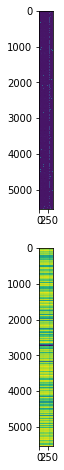

Itr 0, Obj 3703163.224231
Itr 1, Obj 3215482.825605
Itr 2, Obj 3059600.235469
Itr 3, Obj 2962892.127185
Itr 4, Obj 2902112.151224
Itr 5, Obj 2854068.819092
Itr 6, Obj 2813487.063466
Itr 7, Obj 2778491.093786
Itr 8, Obj 2747285.128510
Itr 9, Obj 2719143.311498
Itr 10, Obj 2693654.178471
Itr 11, Obj 2670051.693867
Itr 12, Obj 2648081.713342
Itr 13, Obj 2627227.027851
Itr 14, Obj 2607485.245858
Itr 15, Obj 2588547.151561
Itr 16, Obj 2570161.872201
Itr 17, Obj 2552226.048829
Itr 18, Obj 2534776.345387
Itr 19, Obj 2517823.309932
Itr 20, Obj 2501253.032845
Itr 21, Obj 2485166.057833
Itr 22, Obj 2469700.013620
Itr 23, Obj 2454861.813265
Itr 24, Obj 2440769.117040
Itr 25, Obj 2427471.801765
Itr 26, Obj 2414867.614230
Itr 27, Obj 2403113.676264
Itr 28, Obj 2392032.735854
Itr 29, Obj 2381666.015010
Itr 30, Obj 2371926.267155
Itr 31, Obj 2362696.325109
Itr 32, Obj 2353953.750975
Itr 33, Obj 2345428.549917
Itr 34, Obj 2337159.393647
Itr 35, Obj 2329174.237364
Itr 36, Obj 2321372.520393
Itr 37, Obj

Itr 297, Obj 1733847.368524
Itr 298, Obj 1733204.548611
Itr 299, Obj 1732568.865614


1732568.865614235

In [66]:
yeast_c_cutoff = NetREX(e_yeast_2, c_yeast_2, lmbda)
yeast_c_cutoff.NetREX_algorithm()

In [32]:
predicted = pd.DataFrame(yeast_c_cutoff.S, index=idx_prior2.index, columns=idx_prior2.columns)
predicted.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,1.027901,-0.150159,1.297383,1.853345,0.597507,0.402378,1.408365,1.486806,0.979841,0.801086,...,1.238979,0.806357,0.811389,0.812771,1.326991,0.926668,0.971613,0.923535,0.926540,0.662635
YBR255W,0.617759,1.556899,0.800194,1.156804,1.166338,0.664077,1.116145,1.557481,1.379226,0.664711,...,1.013282,0.779284,1.158303,1.360122,0.917766,1.157873,0.928320,1.071721,1.085151,0.868832
YGR131W,0.390803,1.359218,0.934956,1.268566,0.851712,0.213125,1.216676,2.512992,2.013164,1.053623,...,1.056653,0.601128,1.087312,1.362380,1.462072,1.023950,0.660639,1.580648,0.706188,0.796469
YPL144W,3.078653,3.277936,0.054647,0.386128,-1.167410,-0.242354,2.128348,0.839551,-0.899840,1.288092,...,37.721344,-0.225877,41.414036,2.256730,0.466009,1.901942,0.293434,2.441390,1.245490,-0.255554
YBR135W,0.624174,4.057521,-0.738674,-0.802136,3.544389,2.134920,-1.362979,1.014648,1.463012,0.484223,...,43.532925,-0.566529,0.652063,1.748060,1.514772,2.374071,0.728017,1.835180,1.182399,-0.353526


In [ ]:
predicted.to_csv('../output/yeast_netrex_c_cutoff_morestrict_predicted_network', sep='\t')

In [33]:
x_trans_y = yeast_c_cutoff.X.T.dot(yeast_c_cutoff.Y)

In [34]:
x_tr_y_predicted = pd.DataFrame(x_trans_y, index=idx_prior2.index, columns=idx_prior2.columns)

In [ ]:
x_tr_y_predicted.to_csv('../output/yeast_netrex_c_cutoff_morestrict_x_tr_y', sep='\t')

In [35]:
x_tr_y_predicted.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.996474,0.997532,0.997389,0.997472,0.997458,0.997500,0.997547,0.997318,0.997498,0.995522,...,0.997434,0.997464,0.997440,0.997527,0.997545,0.997426,0.997473,0.997530,0.997523,0.997472
YBR255W,0.996511,0.997598,0.997373,0.997453,0.997454,0.997451,0.997543,0.997398,0.997532,0.995453,...,0.997574,0.997446,0.997483,0.997501,0.997640,0.997492,0.997532,0.997616,0.997542,0.997479
YGR131W,0.995249,0.996137,0.996104,0.995959,0.996111,0.995876,0.996110,0.996029,0.996071,0.994234,...,0.996188,0.996211,0.996143,0.996130,0.996186,0.996089,0.996112,0.996142,0.996081,0.996113
YPL144W,0.995295,0.996232,0.996081,0.996261,0.996166,0.996225,0.996256,0.996038,0.996247,0.994230,...,0.996126,0.996273,0.996187,0.996327,0.996326,0.996077,0.996299,0.996119,0.996229,0.996176
YBR135W,0.994688,0.995493,0.995453,0.995458,0.995432,0.995380,0.995486,0.995378,0.995628,0.993495,...,0.995437,0.995412,0.995430,0.995425,0.995579,0.995367,0.995604,0.995465,0.995425,0.995464


In [ ]:
import dill                            
filepath = './netrexruns'
dill.dump_session(filepath, byref=True)